In [44]:
import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [45]:
from deeprobust.graph.data import Dataset, PrePtbDataset
from deeprobust.graph.utils import preprocess, accuracy
from deeprobust.graph.defense import GCN

In [46]:
data = Dataset(root='./data/', name='cora', setting='prognn') 
perturbed_data = PrePtbDataset(root='./pertubed_data/',
                               name='cora',
                               attack_method='meta',
                               ptb_rate=0.15)

Loading cora dataset...
Selecting 1 largest connected components
Loading cora dataset perturbed by 0.15 meta...


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adj, features, labels = preprocess(data.adj, data.features, data.labels, preprocess_feature=True, device=device)
modified_adj = perturbed_data.adj
modified_adj, features, labels = preprocess(modified_adj, data.features, data.labels, preprocess_feature=True, device=device)

In [48]:
clean_edge_index = adj.nonzero().T
pertub_edge_index = modified_adj.nonzero().T

In [49]:
clean_edge_index

tensor([[   0,    0,    0,  ..., 2484, 2484, 2484],
        [1084, 1104, 1288,  ..., 1184, 1255, 1894]], device='cuda:0')

In [50]:
pertub_edge_index

tensor([[   0,    0,    0,  ..., 2484, 2484, 2484],
        [1084, 1104, 1288,  ..., 1184, 1255, 1894]], device='cuda:0')

In [51]:
mask = torch.zeros_like(pertub_edge_index[0]).bool()
for src, dst in tqdm(clean_edge_index.T):
    mask1 = torch.logical_and(pertub_edge_index[0] == src, pertub_edge_index[1] == dst)
    mask2 = torch.logical_and(pertub_edge_index[1] == src, pertub_edge_index[0] == dst)
    mask += mask1 + mask2

100%|██████████| 10138/10138 [00:01<00:00, 9291.67it/s]


In [52]:
torch.save(mask, './image/cora_real_mask')

In [250]:
model_clean = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max().item()+1, dropout=0.5, lr=0.01, weight_decay=5e-4, device=device).to(device)
model_pertub = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max().item()+1, dropout=0.5, lr=0.01, weight_decay=5e-4, device=device).to(device)

In [275]:
model_clean.fit(features, adj, labels, data.idx_train, data.idx_val)
model_pertub.fit(features, modified_adj, labels, data.idx_train, data.idx_val)

In [276]:
model_clean.eval()
output_clean = model_clean.predict(features, adj).cpu()
acc_clean = accuracy(output_clean[data.idx_test], labels[data.idx_test]).cpu().item()
embed_clean = model_clean.get_embed(features, adj)
print(acc_clean)

0.7428909952606636


In [277]:
model_pertub.eval()
output_pertub = model_pertub.predict(features, modified_adj).cpu()
acc_pertub = accuracy(output_pertub[data.idx_test], labels[data.idx_test]).cpu().item()
embed_pertub = model_pertub.get_embed(features, modified_adj)
print(acc_pertub)

0.6190758293838863


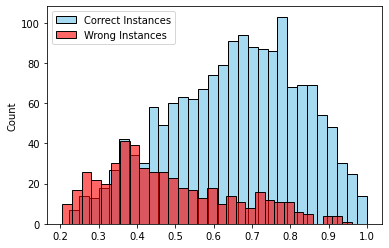

In [68]:
output = model_clean.predict().detach()
false_idx = labels != output.max(1).indices
sns.histplot(data=torch.exp(output.max(1).values[~false_idx].cpu()), 
bins=30, color="skyblue", label="Correct Instances")
sns.histplot(data=torch.exp(output.max(1).values[false_idx].cpu()), 
bins=30, color="red", label="Wrong Instances",  alpha=0.6)
plt.legend()

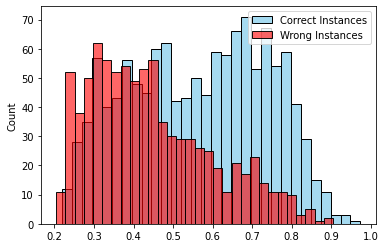

In [69]:
output = model_pertub.predict().detach()
false_idx = labels != output.max(1).indices
sns.histplot(data=torch.exp(output.max(1).values[~false_idx].cpu()), 
bins=30, color="skyblue", label="Correct Instances")
sns.histplot(data=torch.exp(output.max(1).values[false_idx].cpu()), 
bins=30, color="red", label="Wrong Instances",  alpha=0.6)
plt.legend()

In [70]:
embed_pertub = torch.nn.functional.normalize(embed_pertub)
inner_product_pertub = torch.mm(embed_pertub, embed_pertub.T)

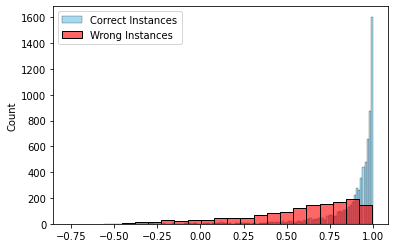

In [71]:
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, mask])].detach().cpu(), color="skyblue", label="Correct Instances")
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), color="red", label="Wrong Instances",  alpha=0.6)
plt.legend()

<AxesSubplot:ylabel='Density'>

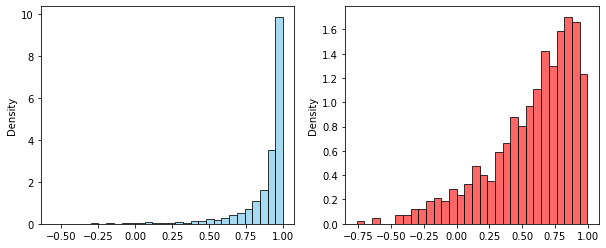

In [72]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color="skyblue", stat='density', label="Correct Instances")
ax1 = plt.subplot(122)
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color="red", stat='density', label="Wrong Instances", alpha=0.6)

<AxesSubplot:ylabel='Count'>

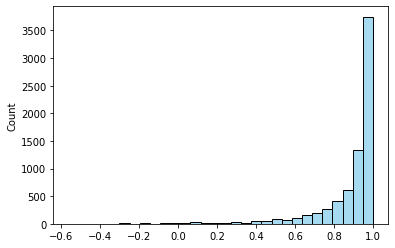

In [73]:
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30,color="skyblue", label="Correct Instances")

In [77]:
i = 0
edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
for src, dst in tqdm(clean_edge_index.cpu().T):
    edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
    mask1 = torch.logical_and(fake_edge_index[i][0] == src, fake_edge_index[i][1] == dst)
    mask2 = torch.logical_and(fake_edge_index[i][1] == src, fake_edge_index[i][0] == dst)
    mask += mask1 + mask2

mask = torch.logical_and(mask, ~edge_mask)

sns.histplot(data=fake_edge_weight[i][mask], bins=30, color='skyblue')
sns.histplot(data=fake_edge_weight[i][~mask], bins=30, color='red', alpha=0.6)

  0%|          | 0/7336 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (8750) must match the size of tensor b (114744) at non-singleton dimension 0

In [ ]:
i = -1
edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
mask = torch.zeros_like(fake_edge_index[0, 0]).bool()
for src, dst in tqdm(clean_edge_index.cpu().T):
    mask1 = torch.logical_and(fake_edge_index[i][0] == src, fake_edge_index[i][1] == dst)
    mask2 = torch.logical_and(fake_edge_index[i][1] == src, fake_edge_index[i][0] == dst)
    mask += mask1 + mask2

mask = torch.logical_and(mask, ~edge_mask)

sns.histplot(data=fake_edge_weight[i][mask], bins=30, color='skyblue')
sns.histplot(data=fake_edge_weight[i][~mask], bins=30, color='red', alpha=0.6)

In [19]:
def _similarity(h1, h2=None):
    if h2 == None:
        h2 = h1
    h1 = torch.nn.functional.normalize(h1)
    h2 = torch.nn.functional.normalize(h2)
    return h1 @ h2.t()

In [ ]:
fake_edge_index = torch.load('fake_edge_index_lp_0.9', map_location='cpu')
fake_edge_weight = torch.load('fake_edge_weight_lp_0.9', map_location='cpu').detach()

i = -1
edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
mask_ = torch.zeros_like(fake_edge_index[0, 0]).bool()
for src, dst in tqdm(clean_edge_index.cpu().T):
    mask1 = torch.logical_and(fake_edge_index[i][0] == src, fake_edge_index[i][1] == dst)
    mask2 = torch.logical_and(fake_edge_index[i][1] == src, fake_edge_index[i][0] == dst)
    mask_ += mask1 + mask2

mask_ = torch.logical_and(mask_, ~edge_mask)

sns.histplot(data=fake_edge_weight[i][mask_], bins=30, color='skyblue')
sns.histplot(data=fake_edge_weight[i][~mask_], bins=30, color='red', alpha=0.6)


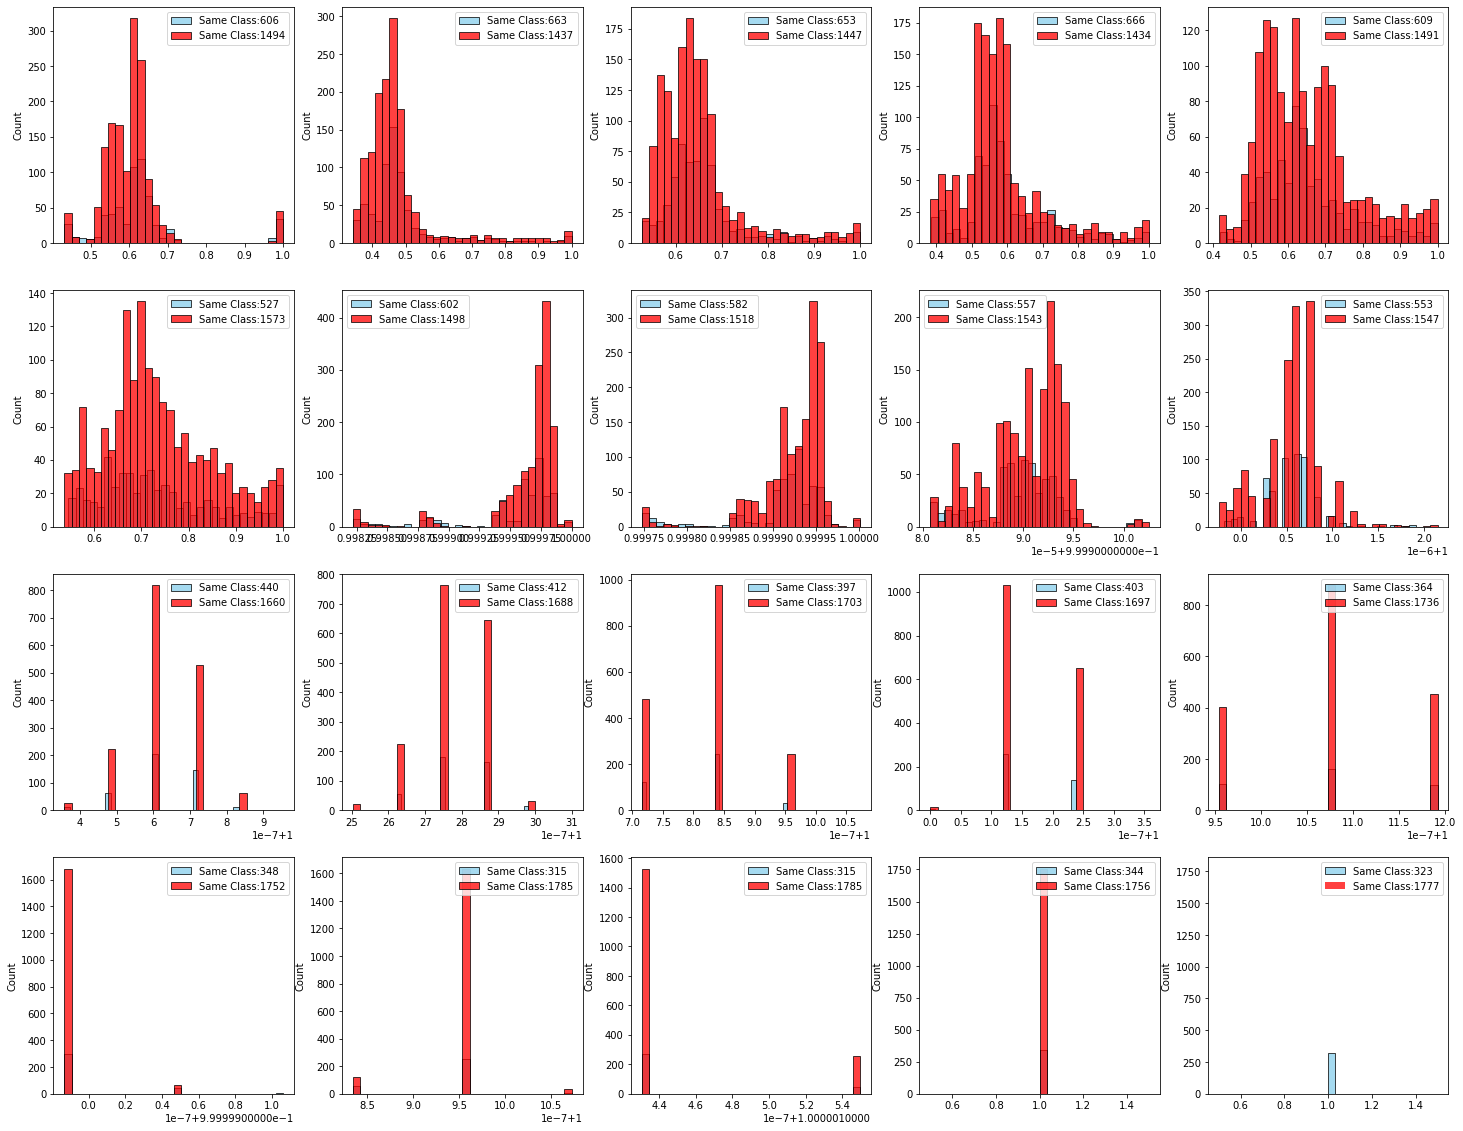

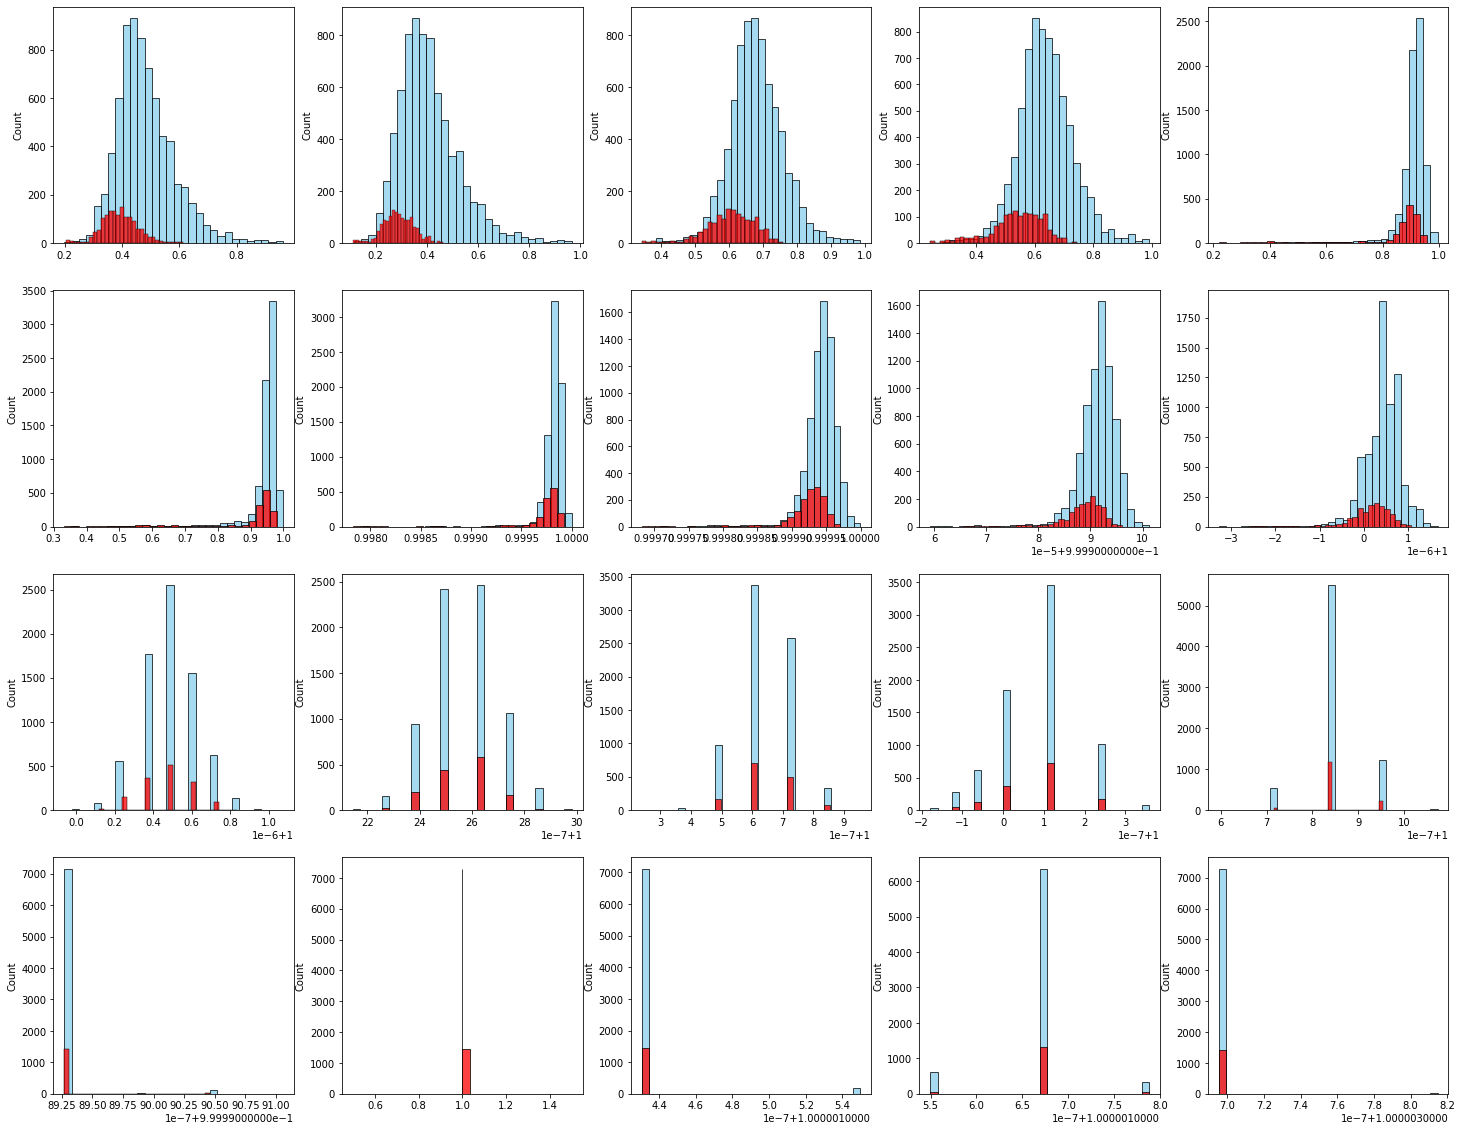

In [92]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_CoG_Edge_Mix').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

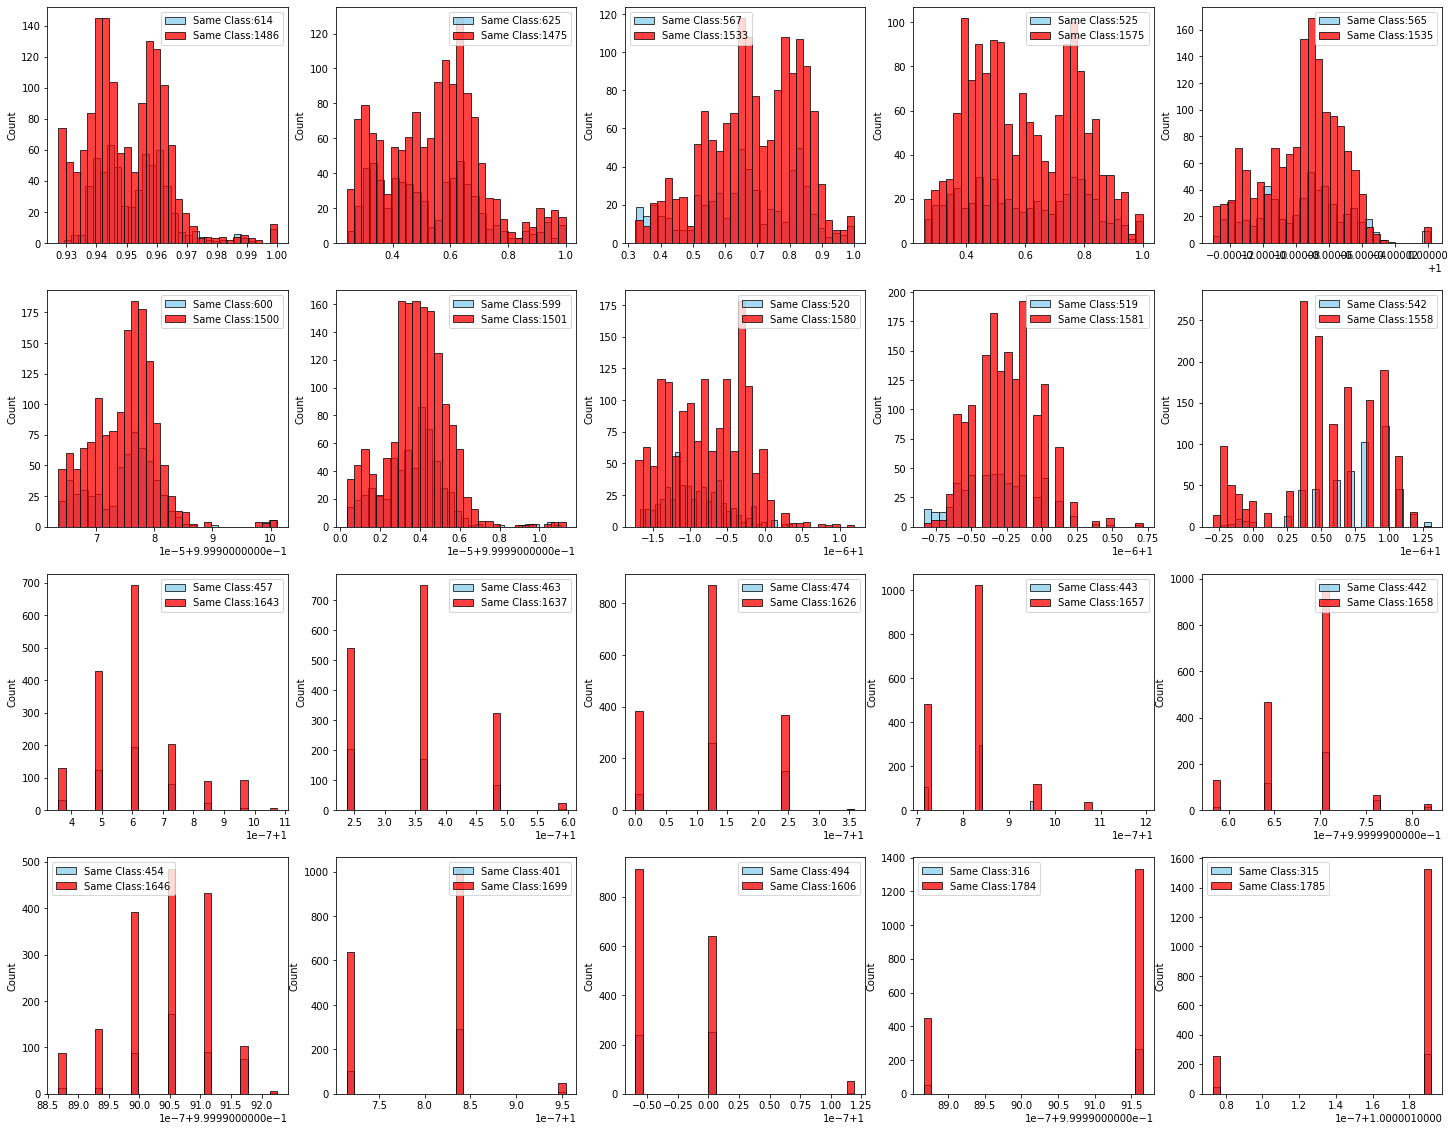

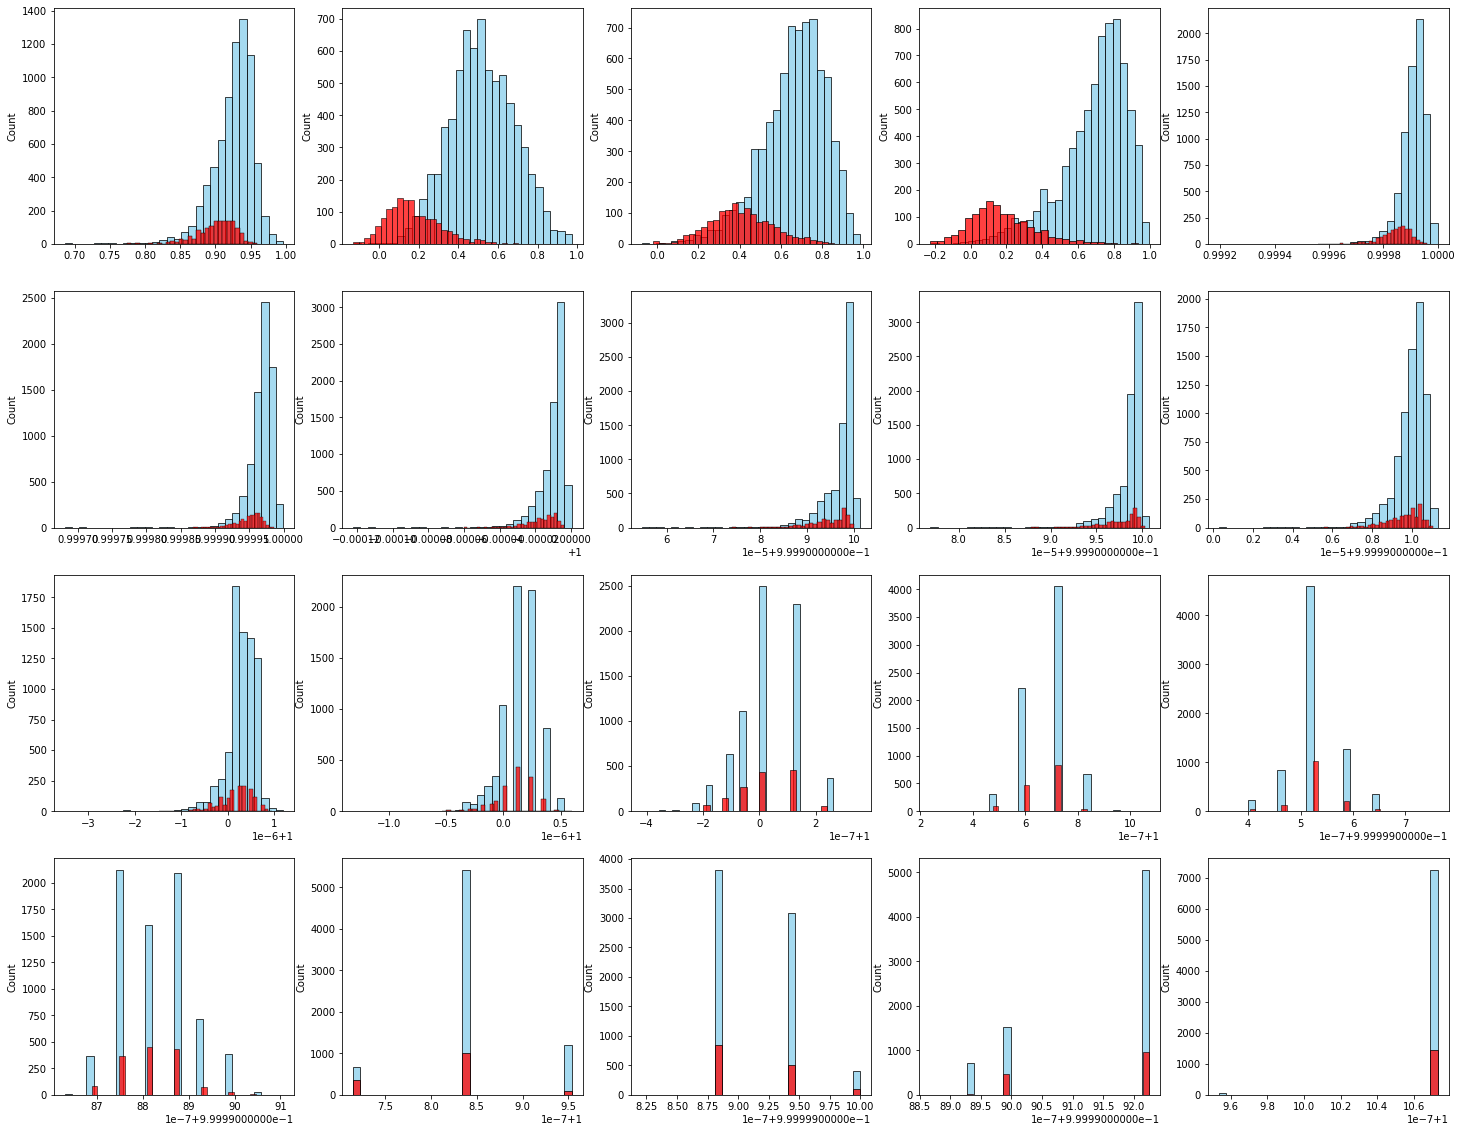

In [93]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_GCL_Edge_Class').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

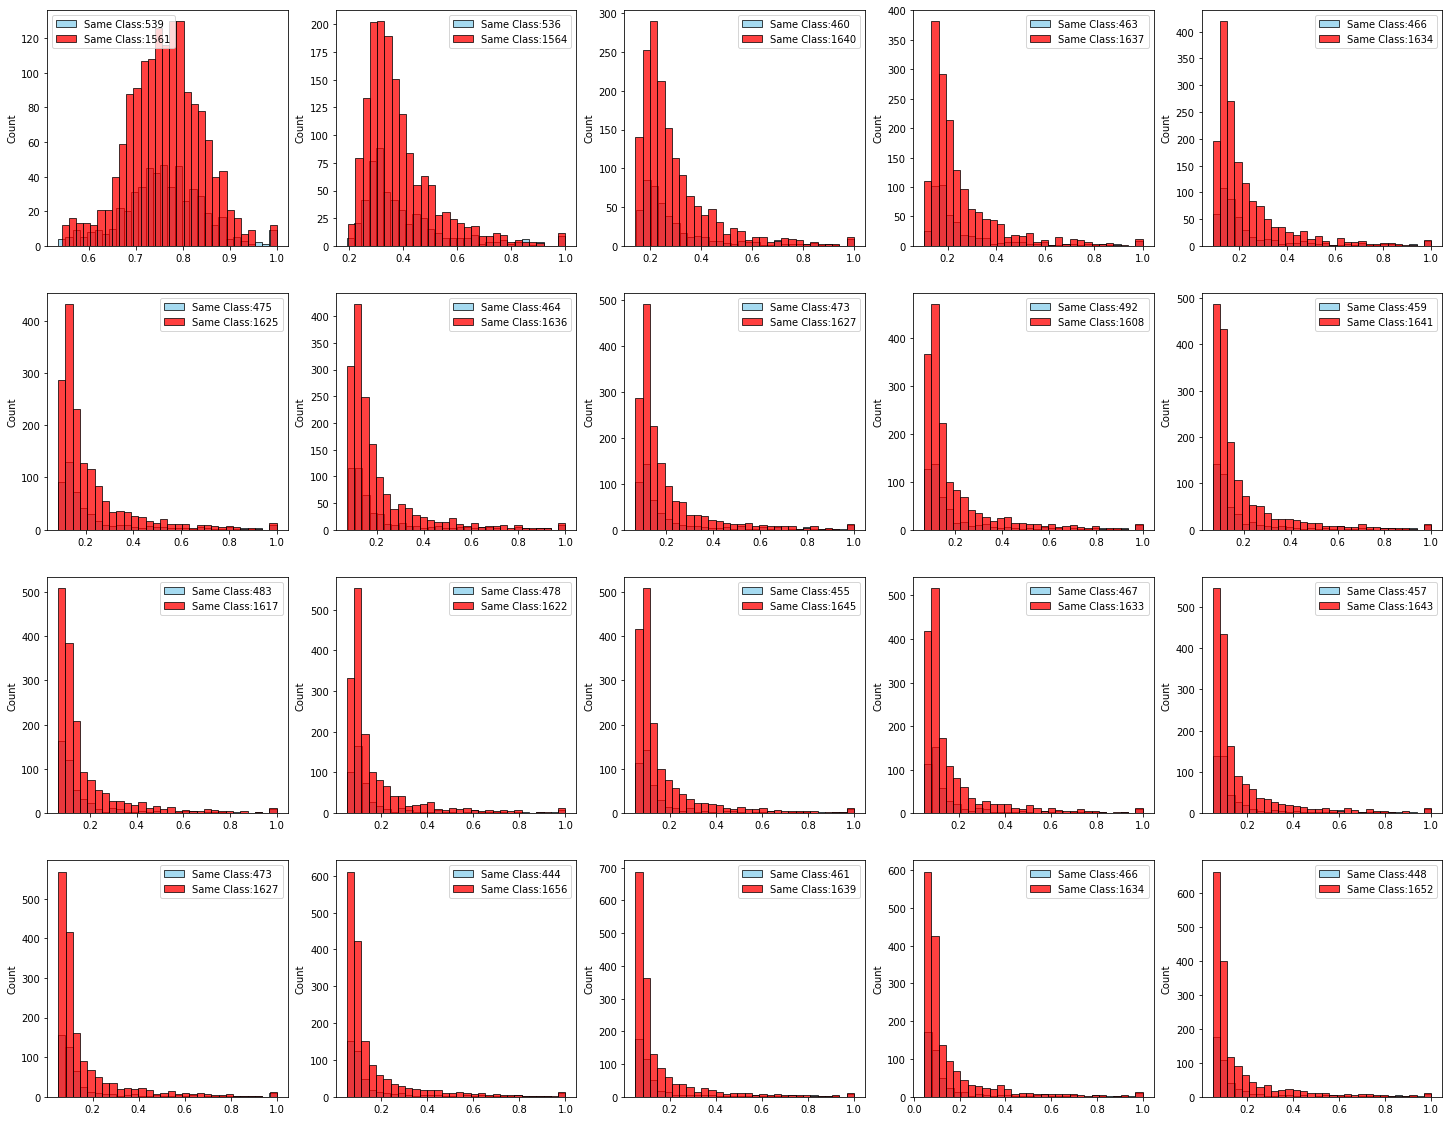

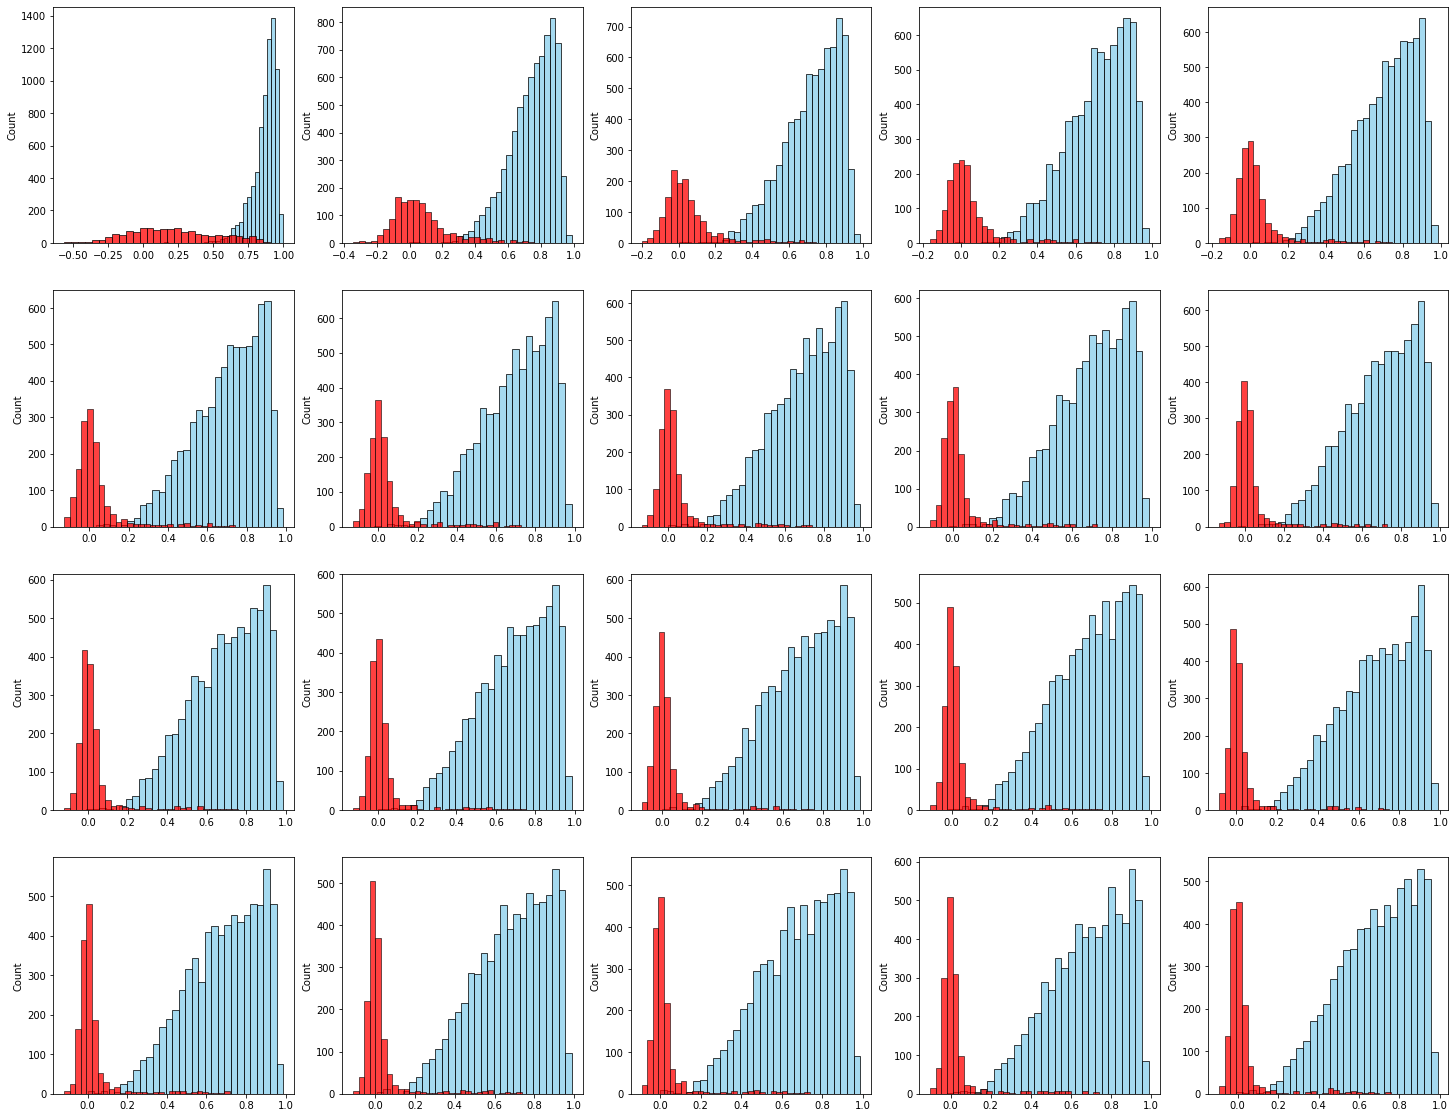

In [98]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Edge_Mix').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

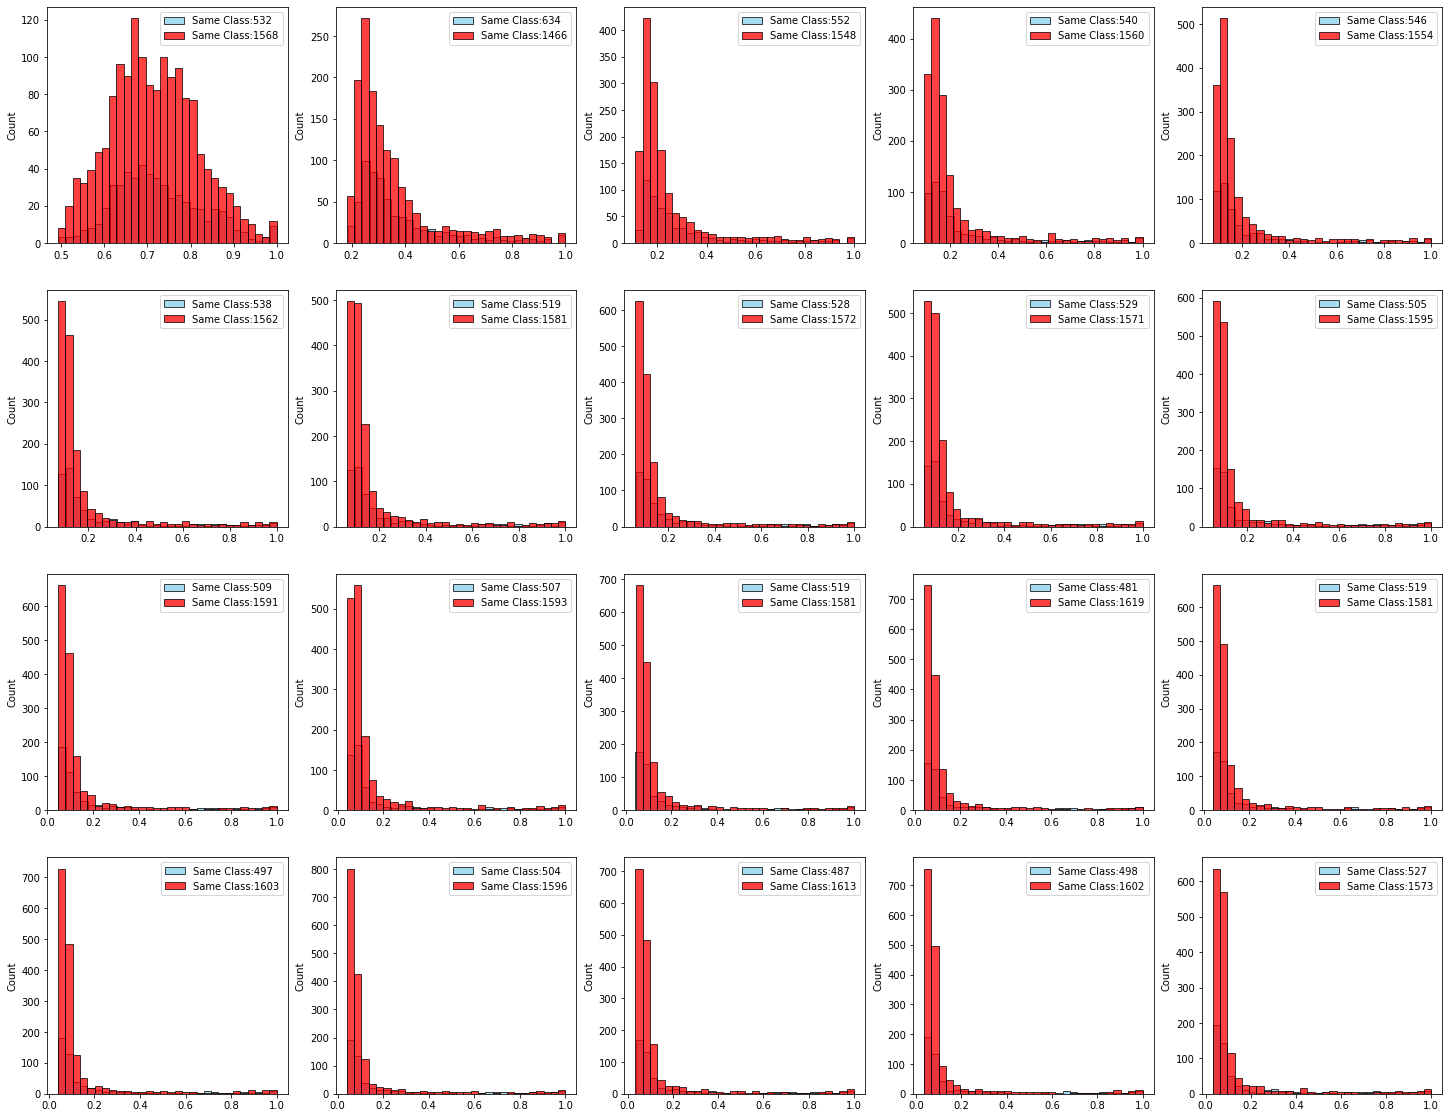

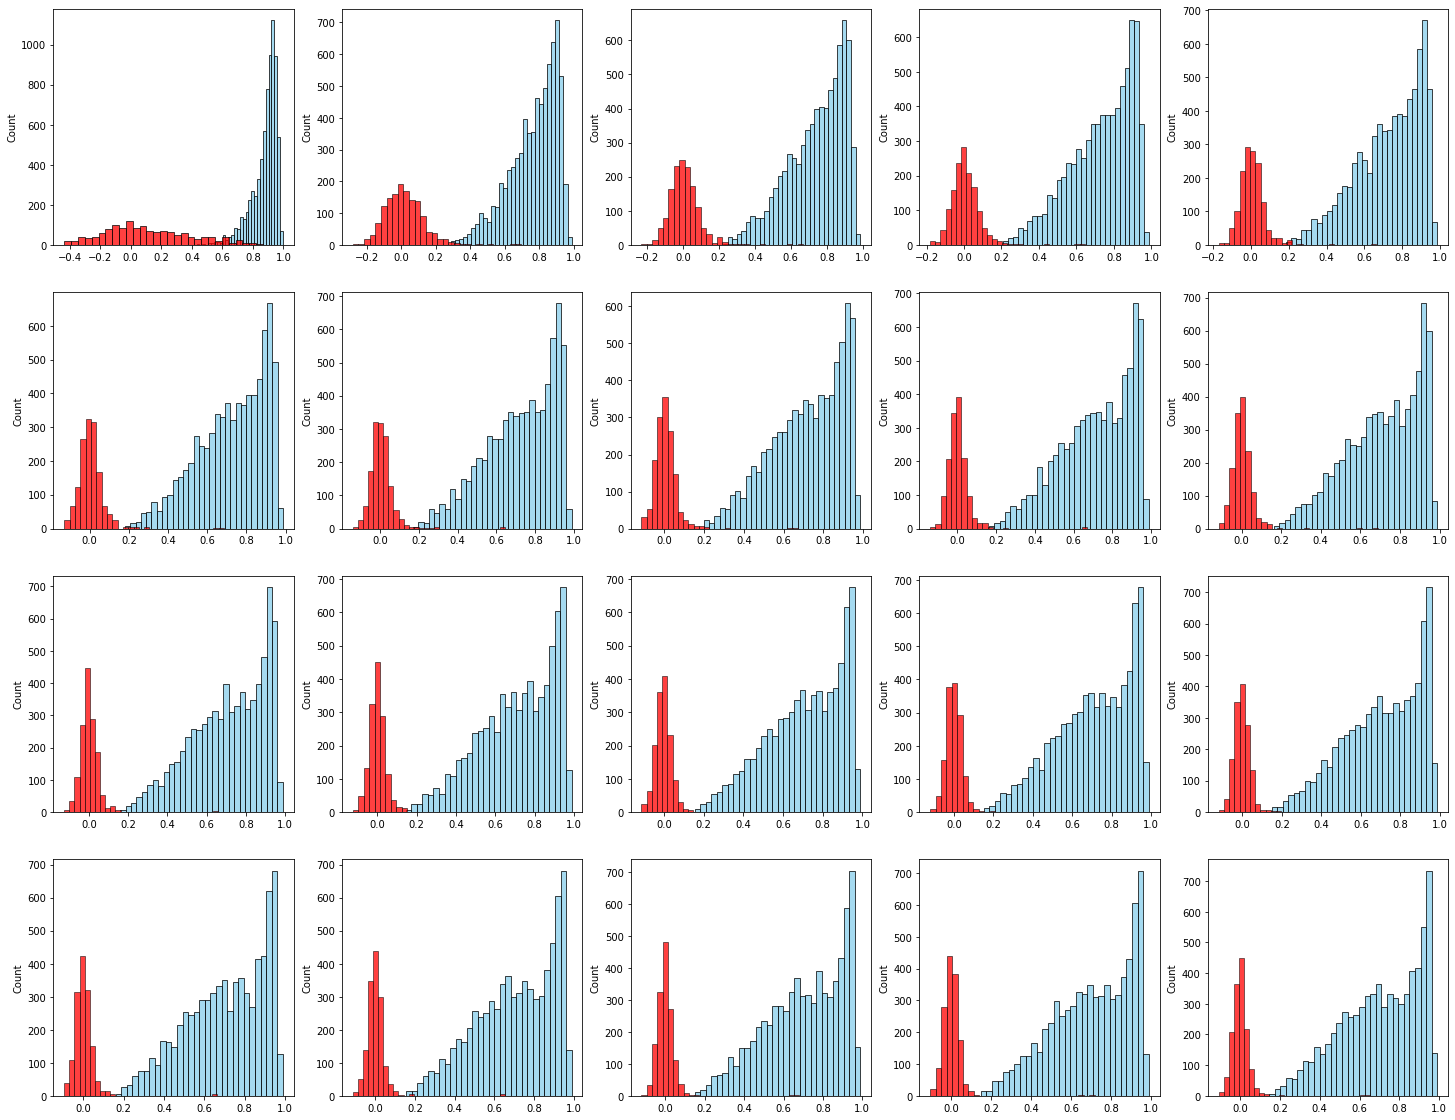

In [97]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Denoise_0.2').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

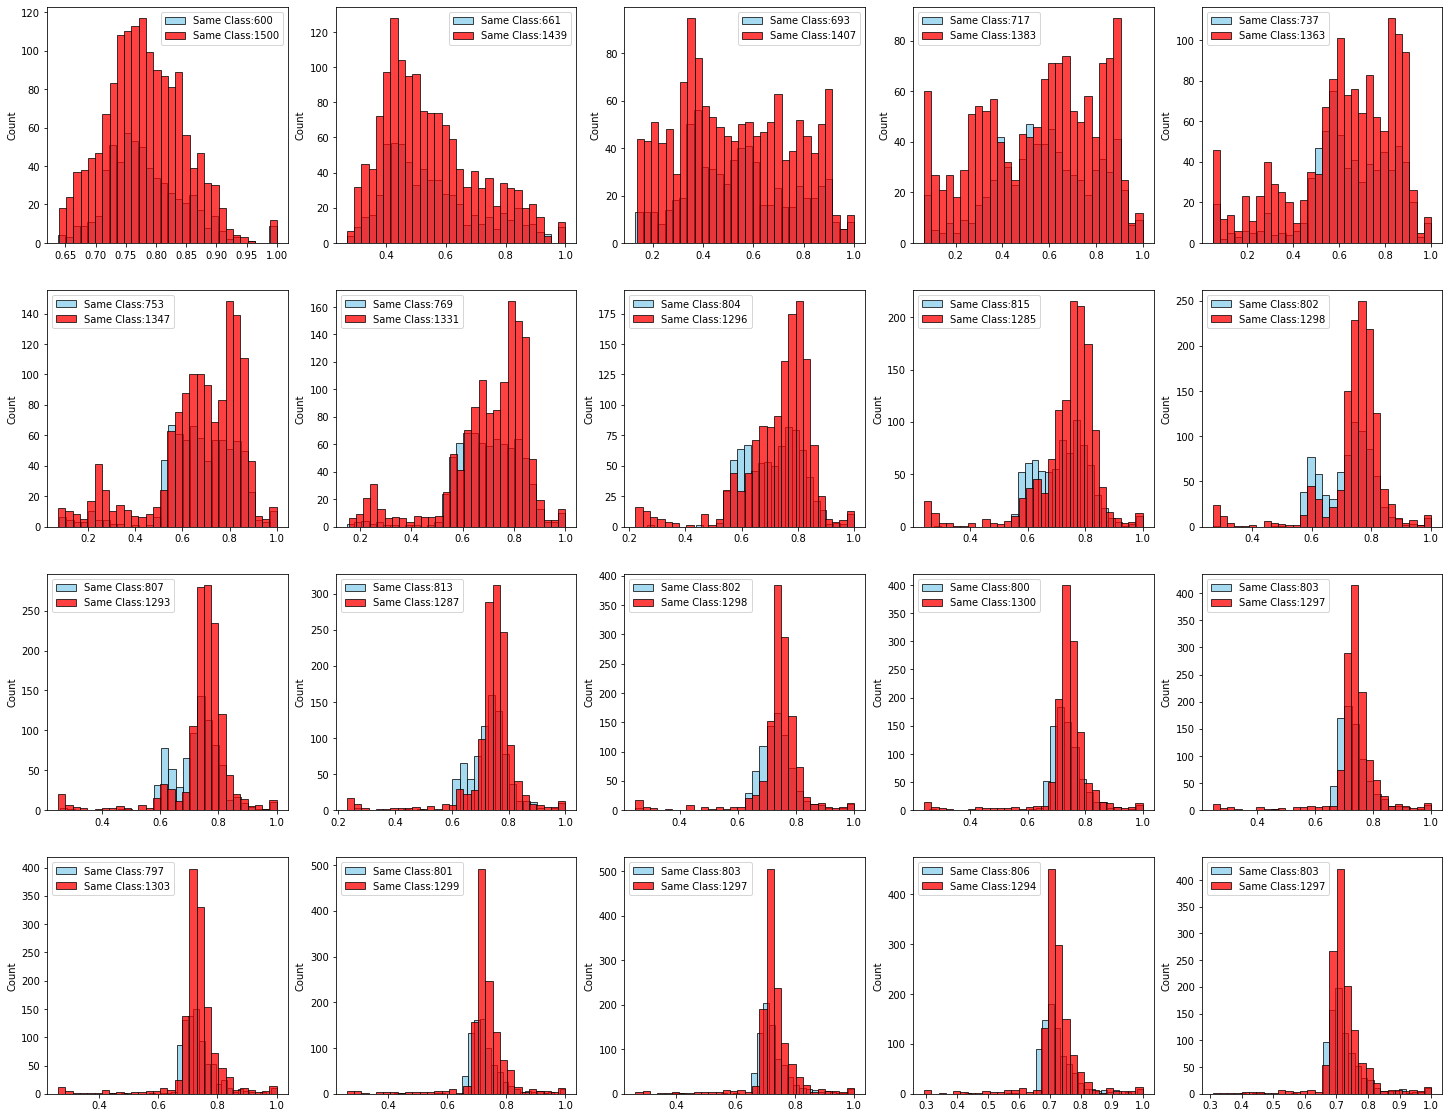

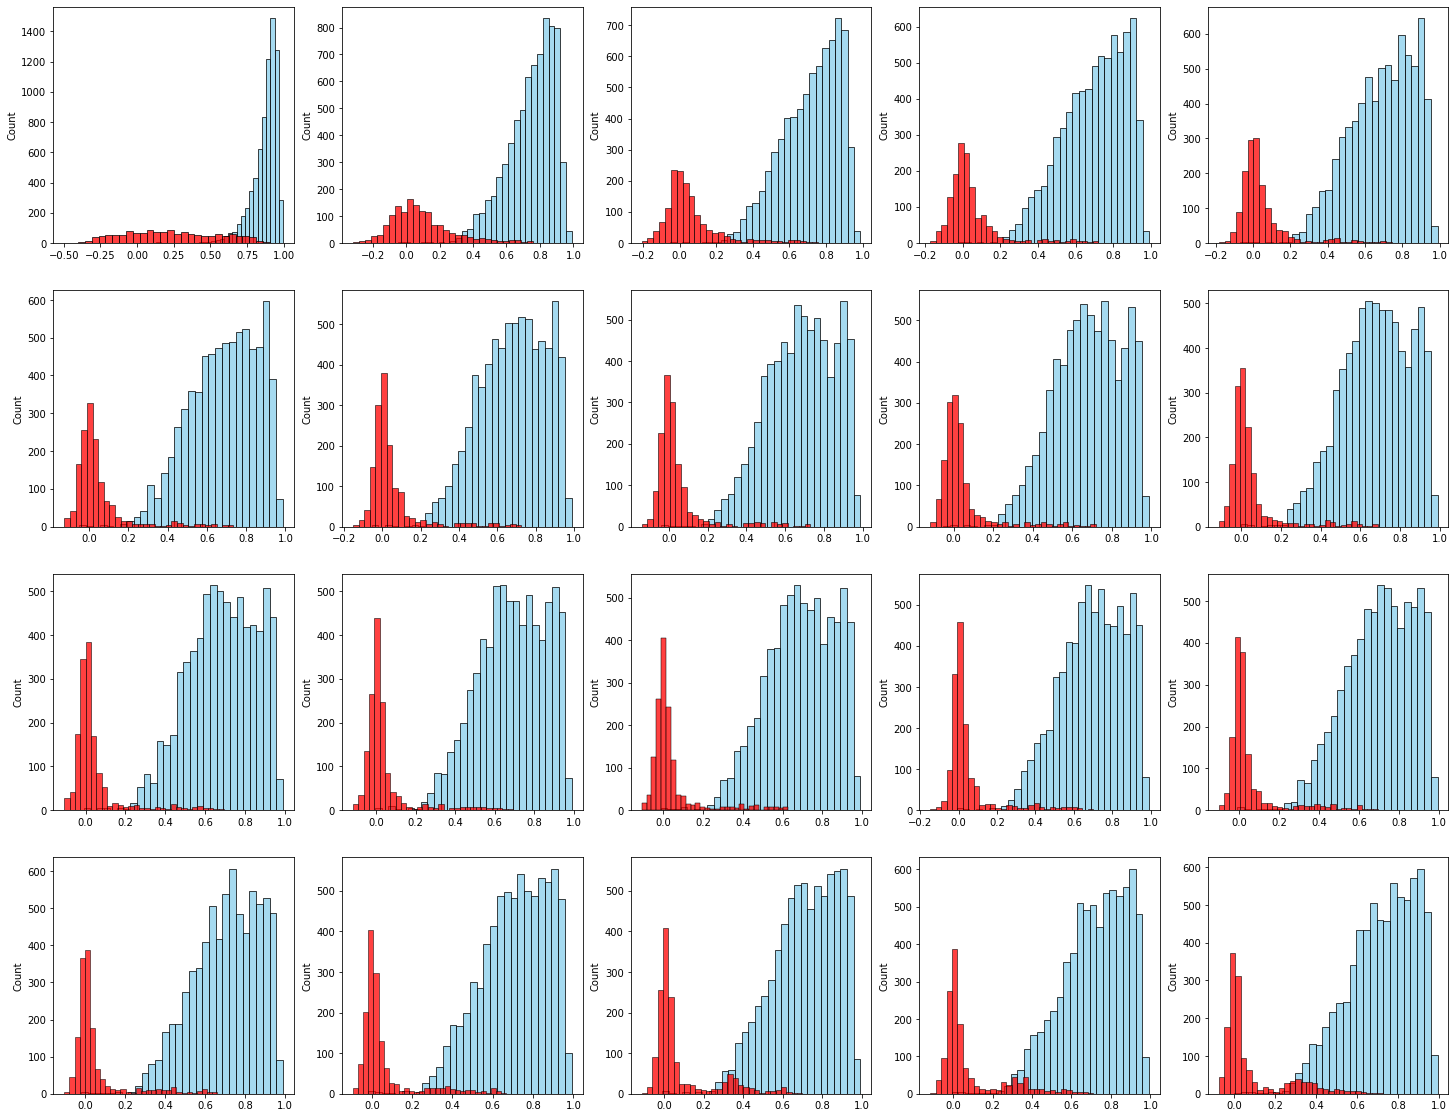

In [101]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Same').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

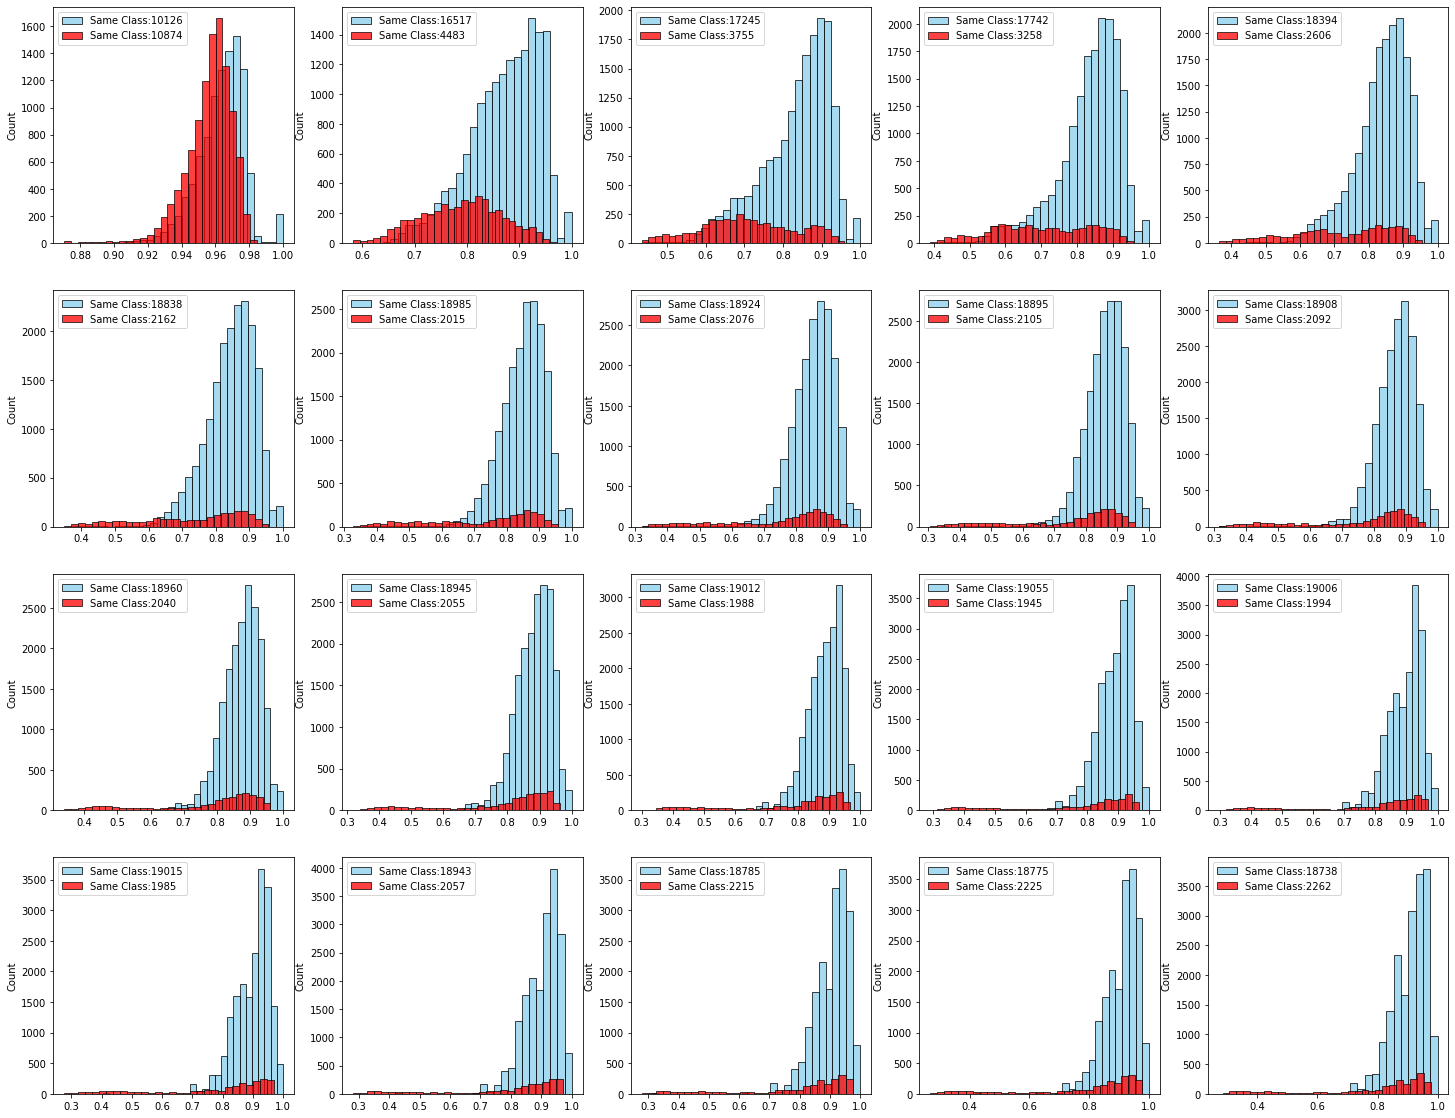

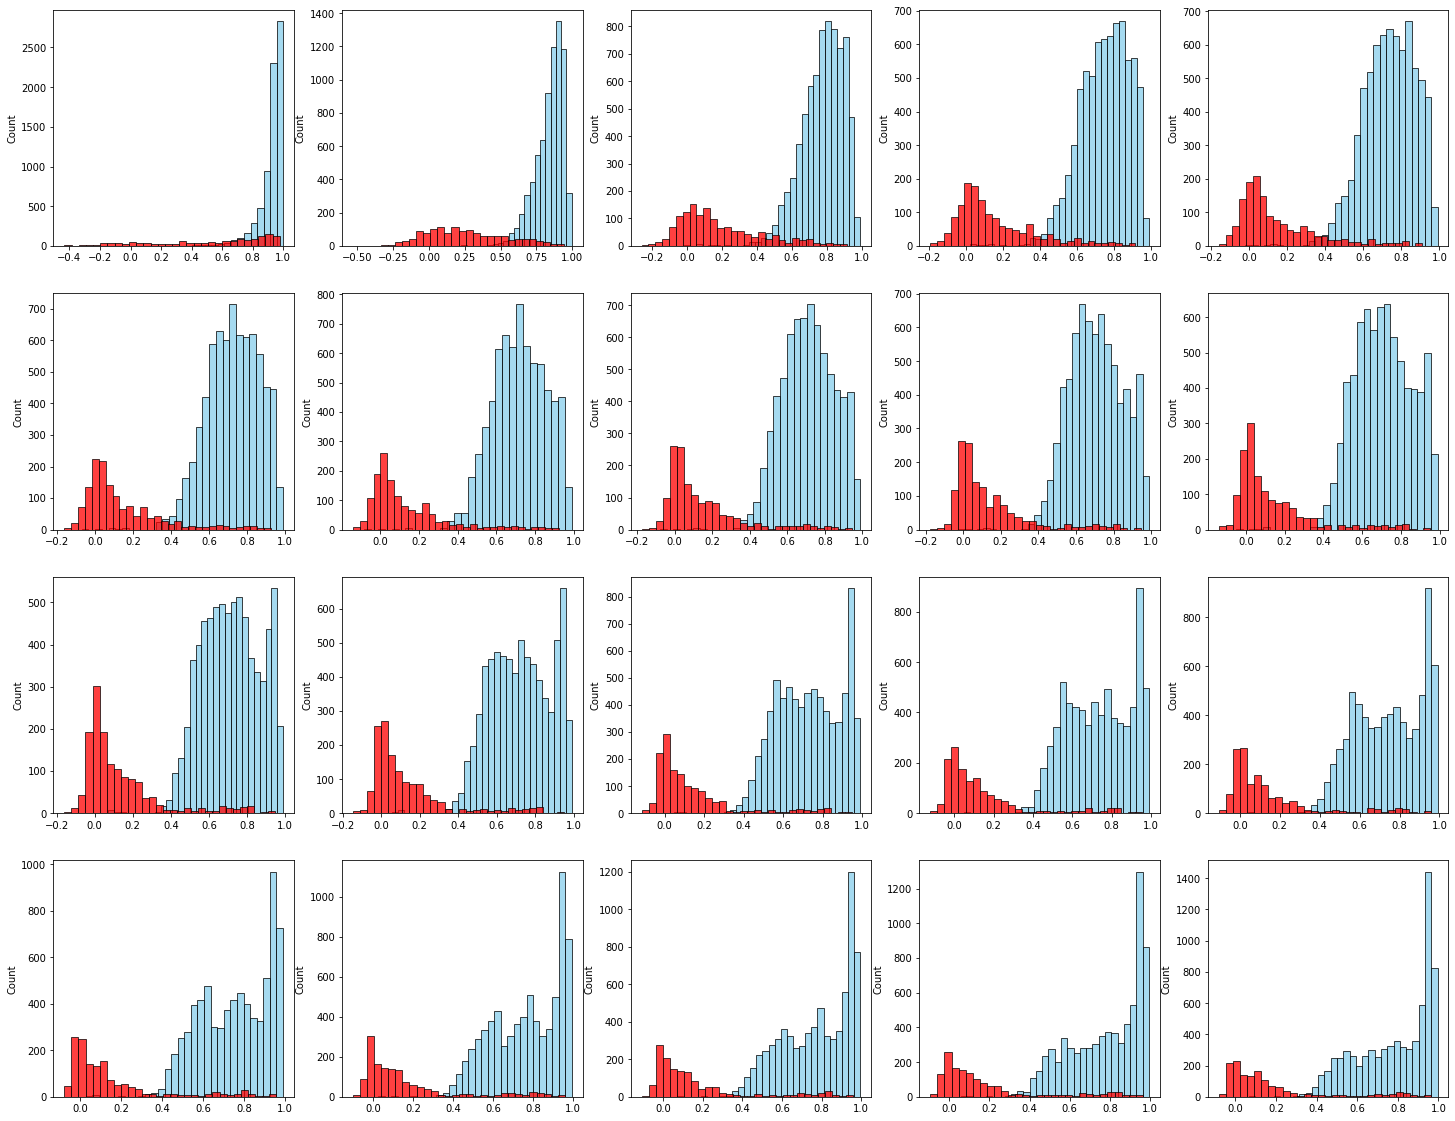

In [102]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Same').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

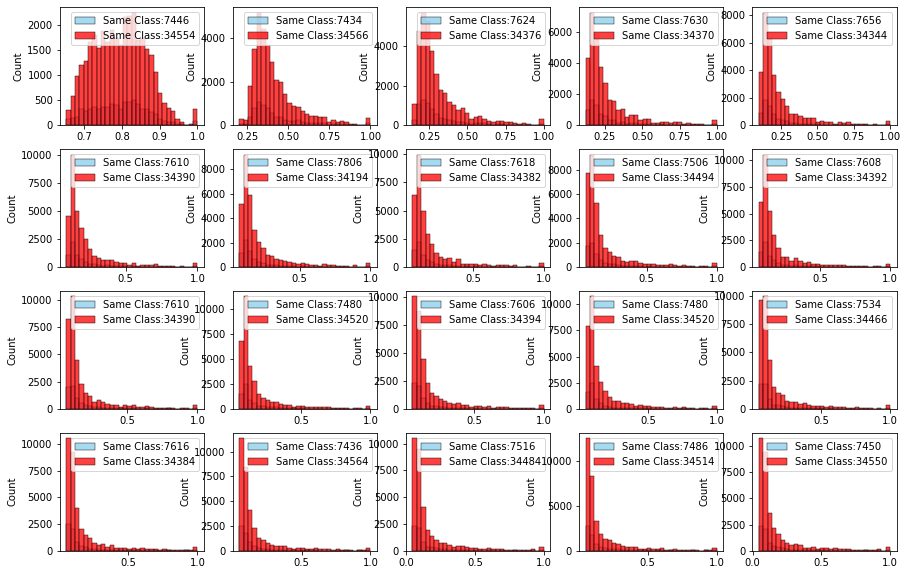

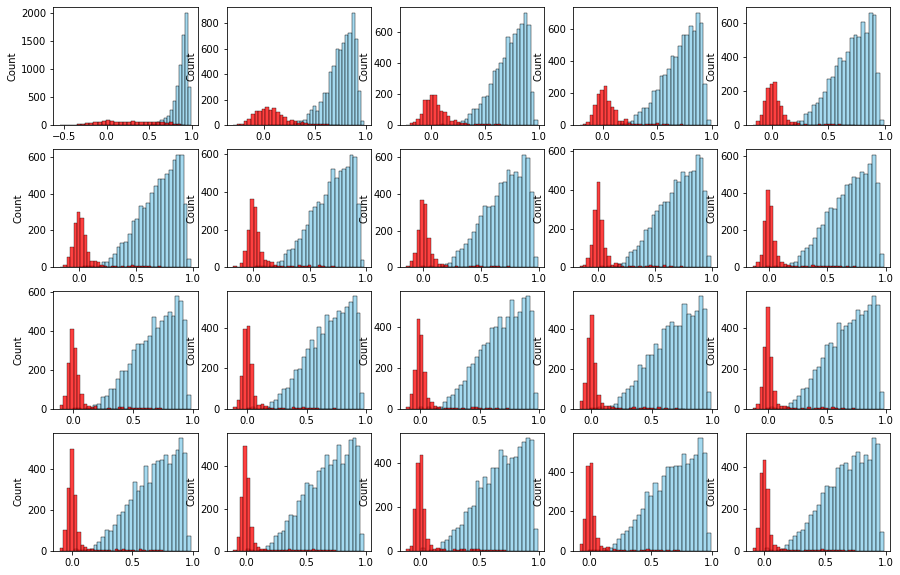

In [113]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Mix_step').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[np.tile(data.idx_train, 20)][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

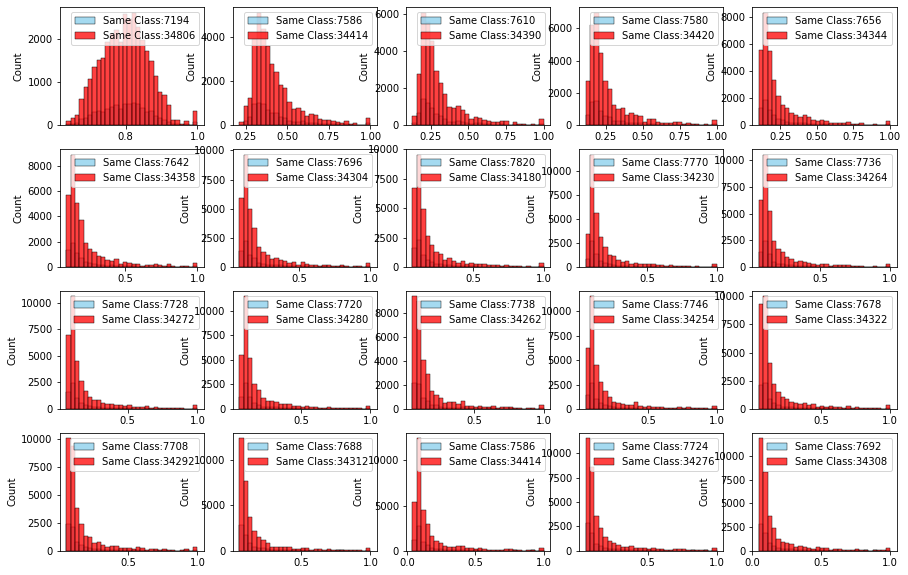

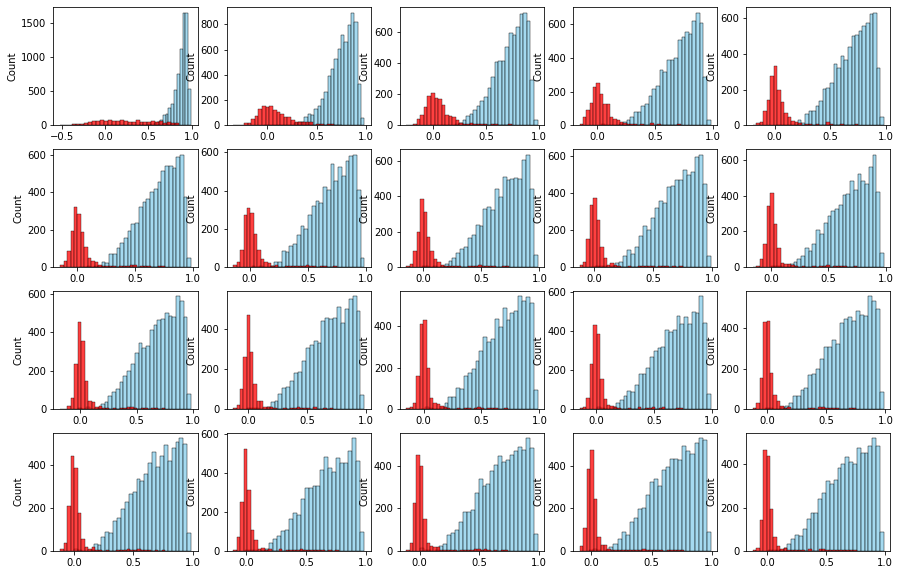

In [114]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Mix_step').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[np.tile(data.idx_train, 20)][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

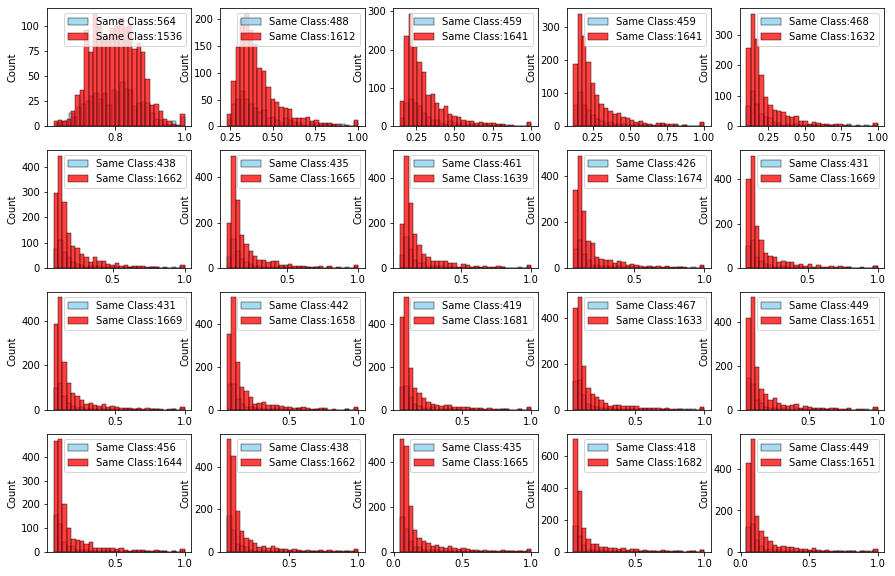

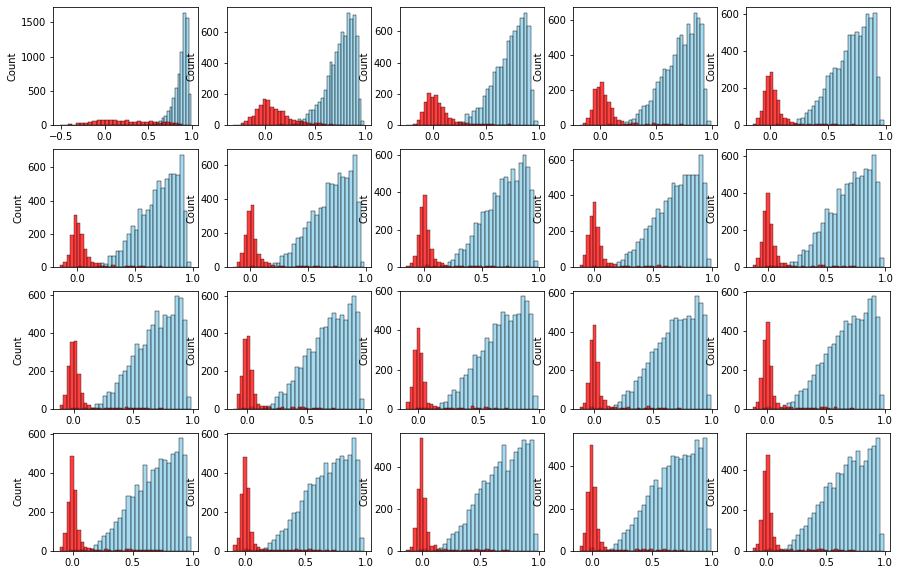

In [135]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Edge_Mix').detach().cpu()

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings[n_real:], embeddings[:n_real])
    mask_ = []
    new_fake_adj = []
    for j, sim in enumerate(fake_adj):
        _, neigbors = sim.topk(100)
        new_fake_adj.append(fake_adj[j, neigbors])
        mask_.append(labels[neigbors] == labels[data.idx_train][j])

    new_fake_adj = torch.stack(new_fake_adj)
    mask_ = torch.stack(mask_)

    sns.histplot(data=new_fake_adj[mask_], bins=30, color='skyblue', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[mask_].size(0)}')
    sns.histplot(data=new_fake_adj[~mask_], bins=30, color='red', stat='count', ax=ax.flatten()[i], label = f'Same Class:{new_fake_adj[~mask_].size(0)}')
    ax.flatten()[i].legend()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])

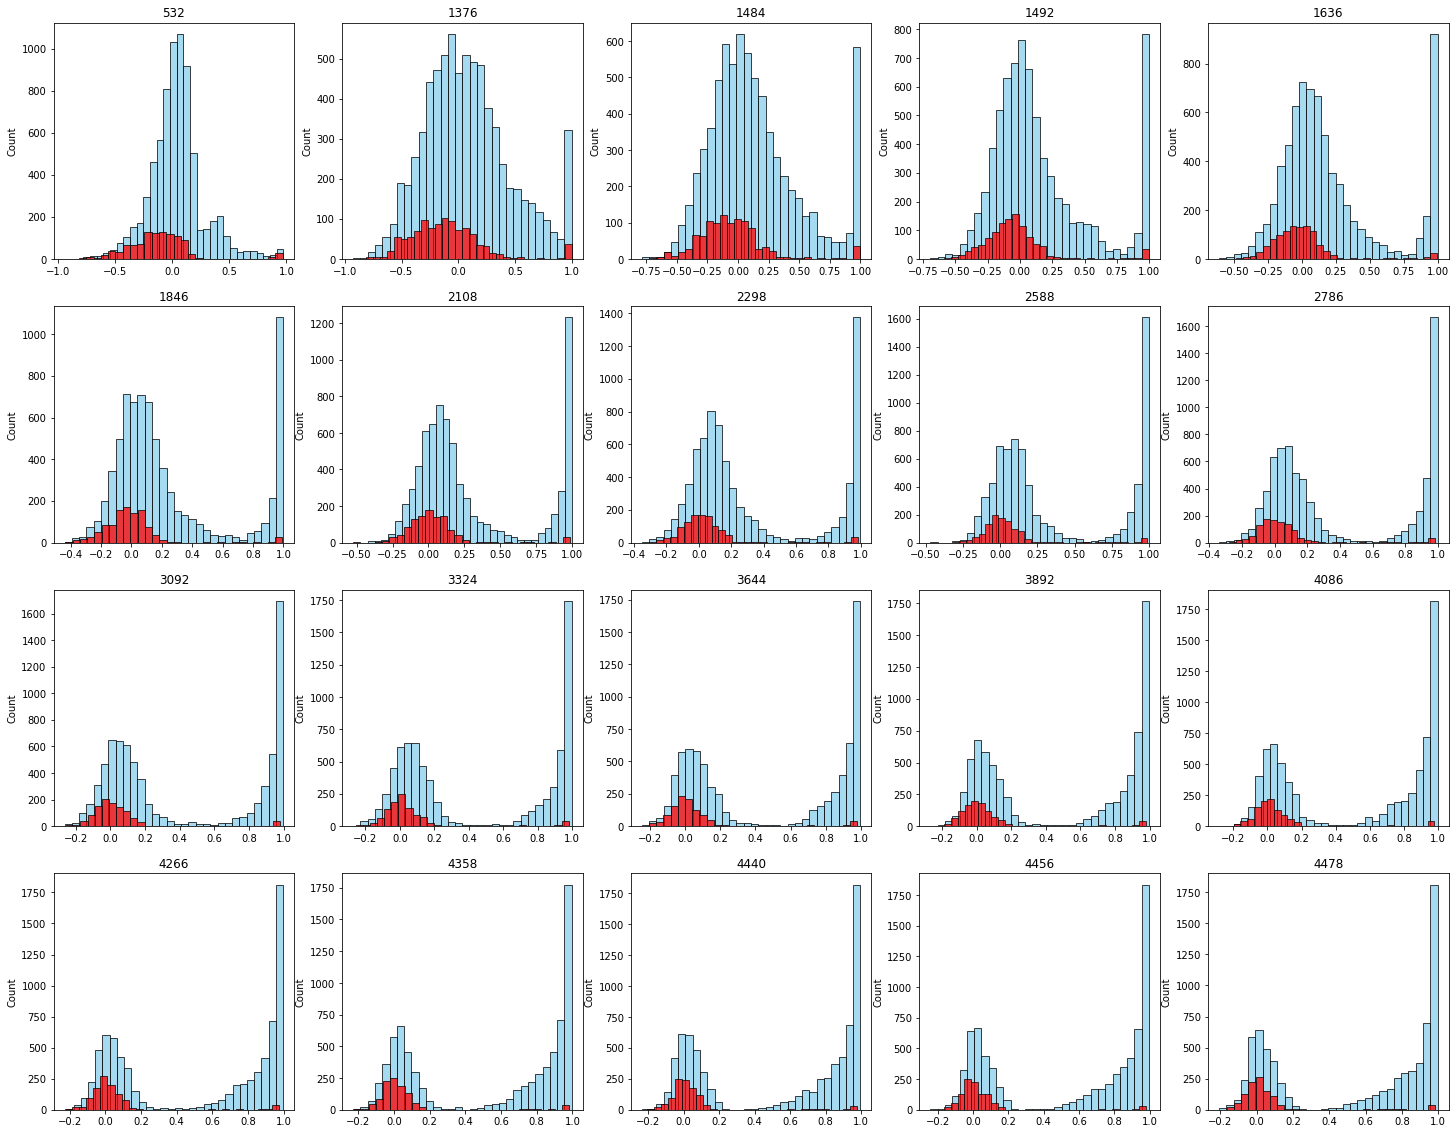

In [246]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Denoise_0.2').detach().cpu()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f'{(fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu() > 0.4).sum().item()}')

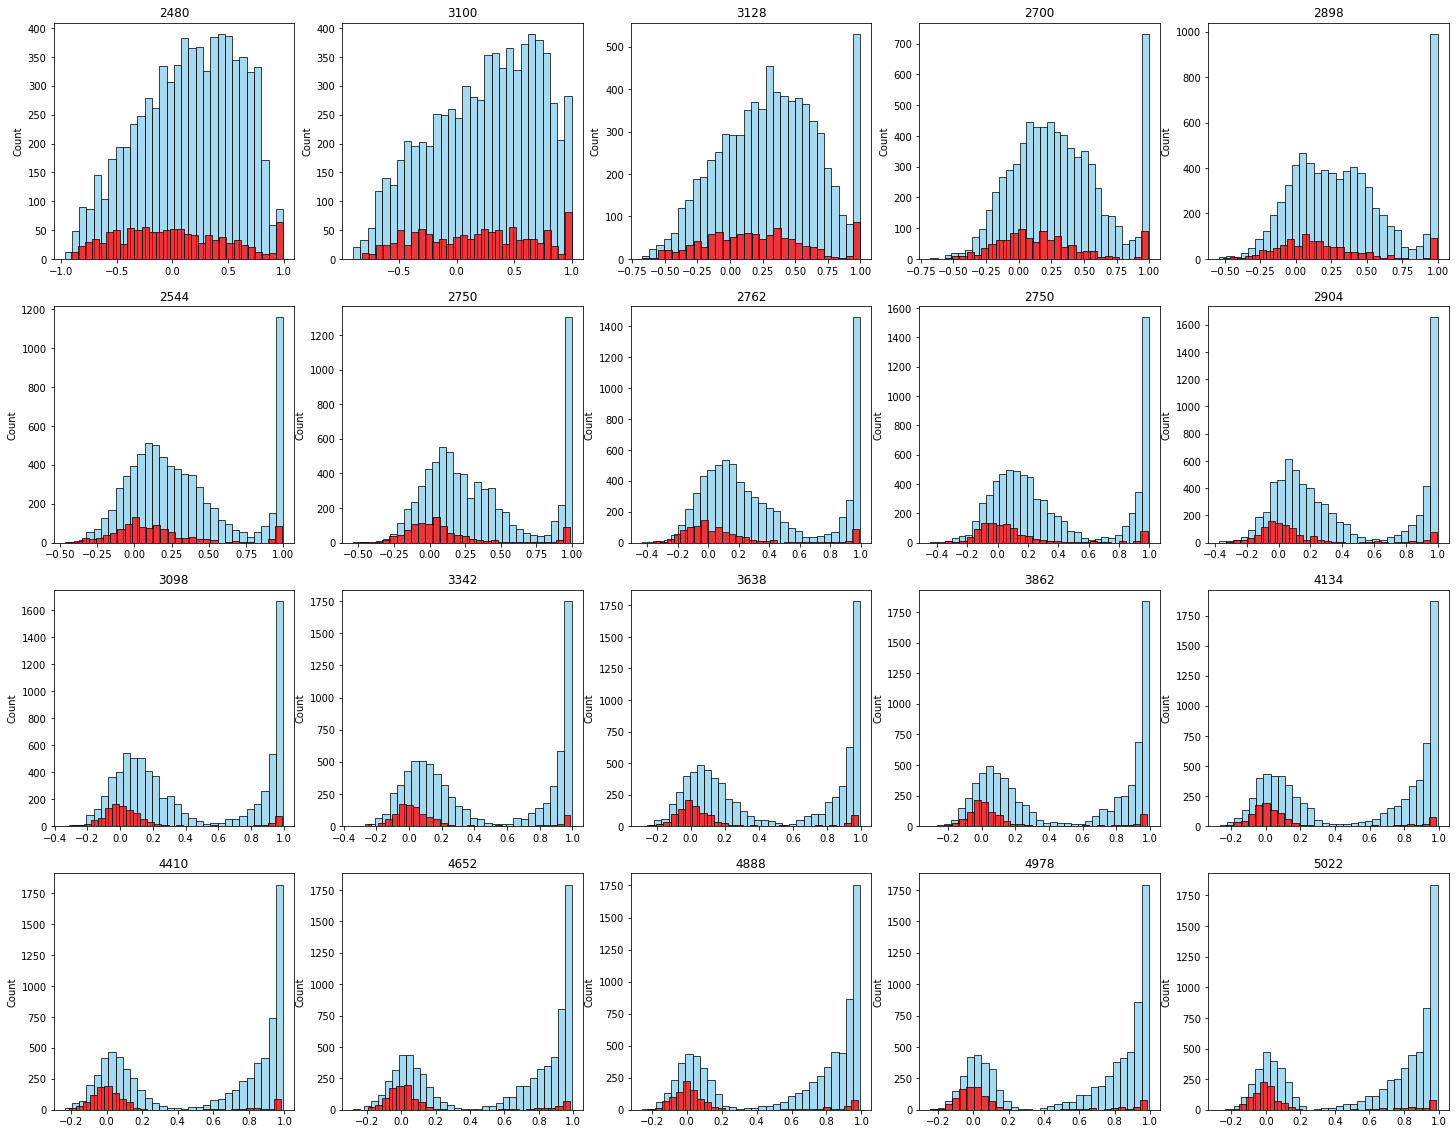

In [38]:
n_real = data.features.shape[0]
all_embeddings = torch.load('fake_adj_LP_Denoise_0.2').detach().cpu()

n_real = data.features.shape[0]
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, embeddings in enumerate(all_embeddings):
    fake_adj = _similarity(embeddings, embeddings)
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color='skyblue', stat='count', ax=ax.flatten()[i])
    sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color='red', stat='count', ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f'{(fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu() > 0.4).sum().item()}')

In [40]:
new_mask = fake_adj[tuple(pertub_edge_index)] > 0.2

In [41]:
torch.unique(pertub_edge_index[:, new_mask]).shape

torch.Size([1873])

In [43]:
torch.unique(clean_edge_index).shape

torch.Size([2110])

In [37]:
torch.arange(2110)[~a]

tensor([  22,   31,   47,   50,   54,   57,   93,   95,  101,  108,  111,  118,
         126,  136,  142,  143,  146,  166,  177,  182,  206,  212,  224,  235,
         252,  254,  269,  277,  281,  288,  301,  309,  310,  312,  315,  316,
         333,  335,  353,  365,  386,  391,  394,  400,  414,  421,  424,  440,
         441,  449,  461,  465,  479,  480,  484,  498,  499,  502,  506,  513,
         518,  523,  530,  532,  538,  548,  554,  560,  563,  564,  568,  578,
         584,  636,  680,  686,  693,  695,  698,  714,  720,  729,  730,  731,
         733,  743,  744,  761,  762,  764,  765,  769,  773,  775,  776,  780,
         806,  812,  820,  821,  824,  825,  842,  845,  867,  872,  873,  883,
         906,  912,  914,  922,  940,  945,  947,  960,  967,  983,  991,  995,
         996,  998, 1004, 1010, 1017, 1032, 1033, 1040, 1043, 1046, 1059, 1061,
        1062, 1068, 1070, 1072, 1096, 1097, 1101, 1111, 1112, 1116, 1127, 1133,
        1147, 1153, 1169, 1174, 1186, 11

In [226]:
(labels[pertub_edge_index[0, ~mask]][~new_mask] != labels[pertub_edge_index[1, ~mask]][~new_mask]).sum()

tensor(932, device='cuda:0')

<AxesSubplot:ylabel='Count'>

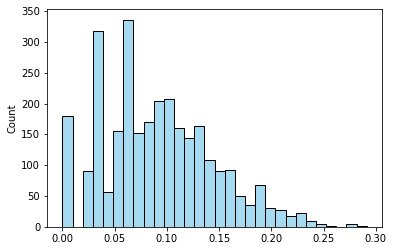

In [235]:
fake_adj = _similarity(features, features)
sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, mask])].detach().cpu()[~new_mask], bins=30, color='skyblue', stat='count')
# sns.histplot(data=fake_adj[tuple(pertub_edge_index[:, ~mask])].detach().cpu()[new_mask], bins=30, color='red', stat='count')

C:\Users\user\anaconda3\envs\ImGAGN\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\envs\ImGAGN\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


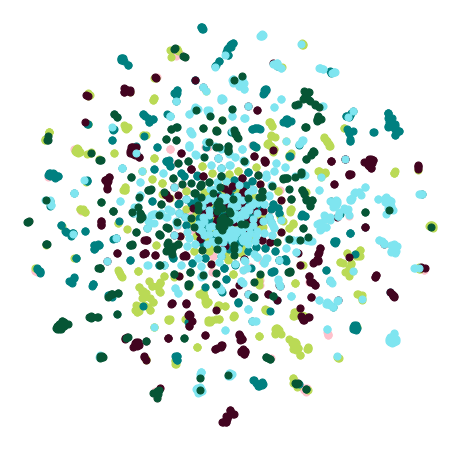

In [23]:
from sklearn.manifold import TSNE

z = TSNE(n_components=2).fit_transform(all_embeddings[15].numpy())
y = labels.cpu().numpy()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535','#ffd700']

plt.figure(figsize=(8, 8))
for i in range(y.max()+1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=50, color=colors[i])
plt.axis('off')
plt.show()

In [1]:
123

123